In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "fecalhospitaloral"

In [2]:
BiocManager::install(c('phyloseq', 'DESeq2'))
library(phyloseq)
library(vegan)
library(ggplot2)
library(DESeq2)
library(randomForest)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: http://cran.rstudio.com/


Bioconductor version 3.12 (BiocManager 1.30.15), R 4.0.5 (2021-03-31)

Installing package(s) 'phyloseq', 'DESeq2'

also installing the dependencies ‘zlibbioc’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘MatrixGenerics’, ‘DelayedArray’, ‘AnnotationDbi’, ‘annotate’, ‘Biobase’, ‘biomformat’, ‘Biostrings’, ‘multtest’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocParallel’, ‘genefilter’, ‘geneplotter’


Old packages: 'ade4', 'adegraphics', 'admisc', 'afex', 'agricolae', 'akima',
  'Amelia', 'animation', 'apcluster', 'ape', 'aplpack', 'aqp', 'arm', 'arrow',
  'arsenal', 'ARTool', 'arules', 'arulesViz', 'astsa', 'autocogs',
  'autothresholdr', 'backports', 'baguette', 'BAS', 'BayesFactor', 'bayesplot',
  'bayestestR', 'bbmle', 'bbotk', 'beeswarm', 'bestNormalize', 'BH',
  'bibliometrix', 'biclust', 'bigr

In [3]:
#more rows and columns
options(repr.matrix.max.cols=200, repr.matrix.max.rows=300)

This is a 16S study of 6 horses that have been treated with an oral antibiotic on day 22-26. They have been sampled before the treatment (day 0-21) but also during the treatment (day 22-26) and after the treatment (day 27-211). The commands below load the data into a phyloseq object (ps) or a summarizedexperiment object (tse)

In [4]:
#seqtab is a count table with countdata with the actual sequence as columnname. Rownames are samplenames
seqtab <- readRDS("/kaggle/input/fecalhospitaloral/seqtab")
seqtab[1:3, 1:3]

CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG
S2T0A  56                                                                                                                                                                                                                                                                                                                                                                                                                                             
S2T0B 109                                                                                                                                                                                                                                                                                                                                                                                                                                             
S2T0C 157                                                                                                                                                                                                                                                                                                                                                                                                                                             
      CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG
S2T0A  55                                                                                                                                                                                                                                                                                                                                                                                                                                             
S2T0B   8                                                                                                                                                                                                                                                                                                                                                                                                                                             
S2T0C 211                                                                                                                                                                                                                                                                                                                                                                                                                                             
      CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGAAGGATGACGGCCCTATGGGTTGTAAACTTCTTTTTCCGGGGGATAAAGTGACCCACGTGTGGGTTATTGCAGGTACCCGGTGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGAAATGTAAGTCAGCCGTCAAATCGCGGAGCTCAACTCCGTCCAGCGGTTGAAACTGCGTTTCTTGAGTGCGCAAGAGGCAGGTGGAATTCGAGGTGTAGCGGTGAAATGCTTAGATATCTCGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGGGCGCAACTGACGCTGAGGCTCGAAGGTGCGGGTATCAAACAGGATTAG
S2T0A 137                                               

In [5]:
# taxa is a table w/ the sequence as rownames & several columns w/ taxa info
taxa <- readRDS('/kaggle/input/fecalhospitaloral/taxa')
head(taxa)

Kingdom 
CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG Bacteria
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG Bacteria
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGAAGGATGACGGCCCTATGGGTTGTAAACTTCTTTTTCCGGGGGATAAAGTGACCCACGTGTGGGTTATTGCAGGTACCCGGTGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGAAATGTAAGTCAGCCGTCAAATCGCGGAGCTCAACTCCGTCCAGCGGTTGAAACTGCGTTTCTTGAGTGCGCAAGAGGCAGGTGGAATTCGAGGTGTAGCGGTGAAATGCTTAGATATCTCGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGGGCGCAACTGACGCTGAGGCTCGAAGGTGCGGGTATCAAACAGGATTAG  Bacteria
CAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTGTACGGGAATAAAGTGACCTACGTGTAGGTTTTTGCATGTACCGTAAGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTGCTTTAAGCGTGTTGTGAAATGTAGGCGCCCAACGTCTGCACTGCAGCGCGAACTGGAGCACTTGAGTACGCAGGAAGTAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGGGAAGCCAGCTTACTGTAGCGCCACTGACGCTGATGCTCGAAAGCGTGGGTATCGAACAGGATTAG Bacteria
CAGTGGGGAATATTGGACAATGGGGGAAACCCTGATCCAGCGACGCCGCGTGAGTGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAAGGAAGAAAATGACGGTACTTGACTAAGAAGCTCCGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAAGCAAGTCTGAAGTGAAATCCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTAGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAG                     Bacteria
CAGTAGGGAATATTGGGCAATGGAGGCAACTCTGACCCAGCCATGCCGCGTGAAGGAAGACGGCCCTATGGGTTGTAAACTTCTTTTATCGTAGAGTAAACCTGGCCACGTGTGGCCAGCTGAGAGTATACGAGGAATAAGTATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGGGGATACGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGATCGGTAAGTCAGGGGTGAAAAGTTGGGGCTCAACTCCAATCGTGCCTTTGATACTGCCGGACTAGAGTGCGATAGACGTGGCCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATCGAGAAGTCAGGTCACGAGCTCGCAACTGACGCTCAGGCACGAAAGCGTGGGGATCAAACAGGATTAG Bacteria
                                                                                                                                                                                                                                                                                                                                                                                                                                                 Phylum       
CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG Bacteroidetes
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG Bacteroidete

In [6]:
# sampledata 
sampledata <- readRDS('/kaggle/input/fecalhospitaloral/sampledata')
head(sampledata)

Day Horse     category       
S2T0A 0   Jeffrey   beforetreatment
S2T0B 0   Joep      beforetreatment
S2T0C 0   Macho     beforetreatment
S2T0D 0   Ruud      beforetreatment
S2T0E 0   Sproetje  beforetreatment
S2T0F 0   Tomboy    beforetreatment

# Tasks
1. What OTUs should we consider the most affected by the treatment?

2. After how many days does the microbiome return to pre-treatment state using ML methods?

3. Explain how we can identify the correct day.

In [7]:
# get data into phyloseq
ps <- phyloseq(otu_table(seqtab, taxa_are_rows = F),
              sample_data(sampledata),
              tax_table(taxa))

In [8]:
ps <- rarefy_even_depth(ps)

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

693OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [9]:
# Remove very low abundant OTUs
minTotRelAbun <- 1e-4
x <- taxa_sums(ps)
keepTaxa <- (x / sum(x)) > minTotRelAbun
ps.pruned <- prune_taxa(keepTaxa, ps)

In [10]:
ps.pruned

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1560 taxa and 198 samples ]
sample_data() Sample Data:       [ 198 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1560 taxa by 7 taxonomic ranks ]

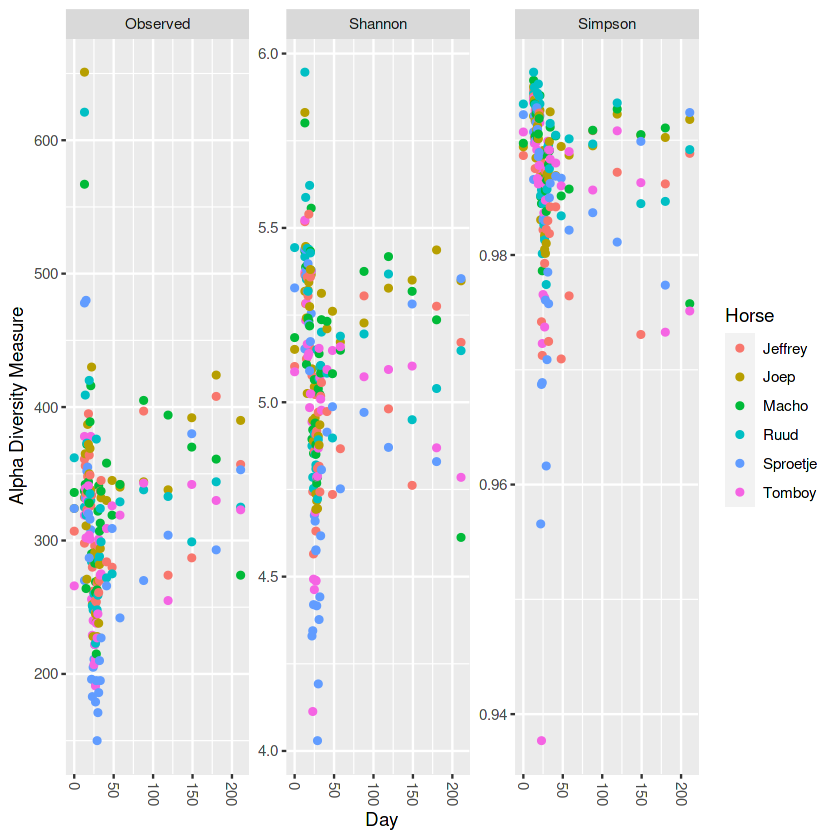

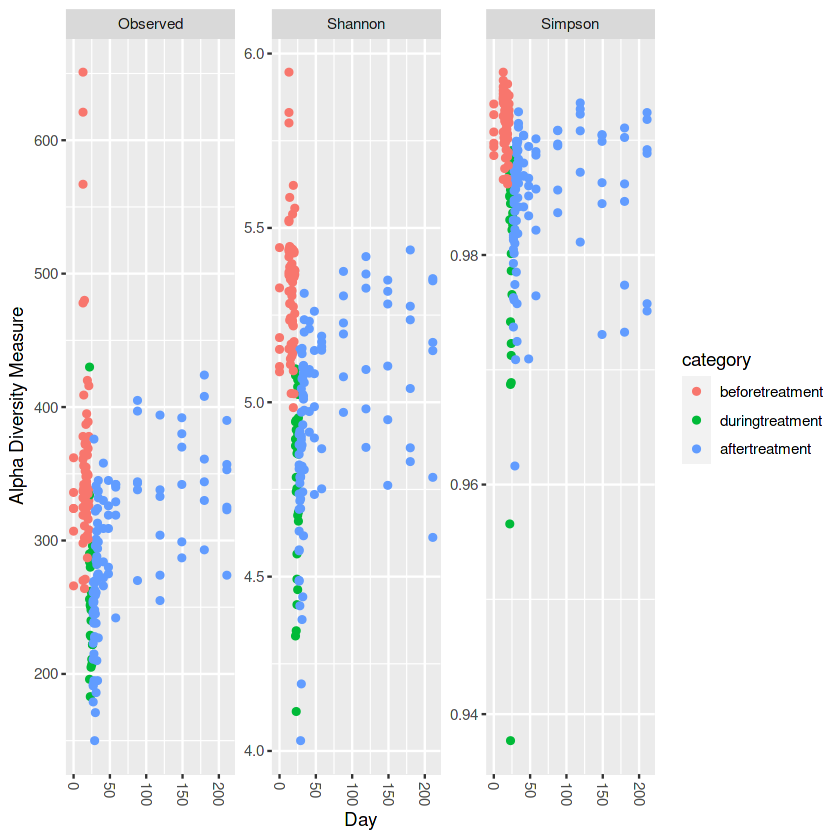

In [11]:
plot_richness(ps.pruned, x='Day', measures=c('Observed', 'Shannon', 'Simpson'), color='Horse')
plot_richness(ps.pruned, x='Day', measures=c('Observed', 'Shannon', 'Simpson'), color='category')

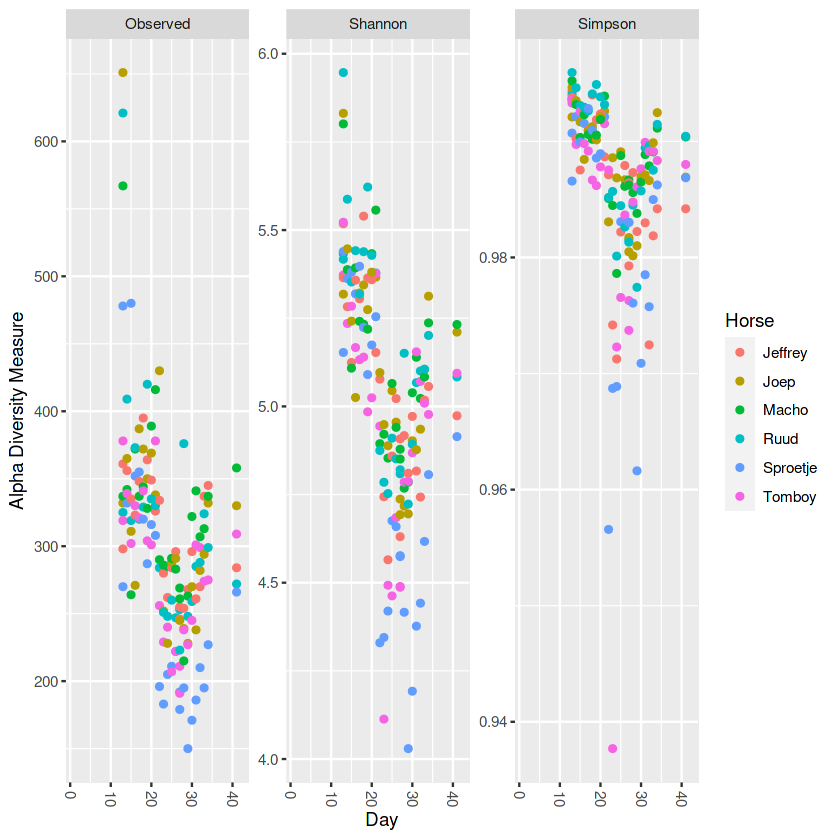

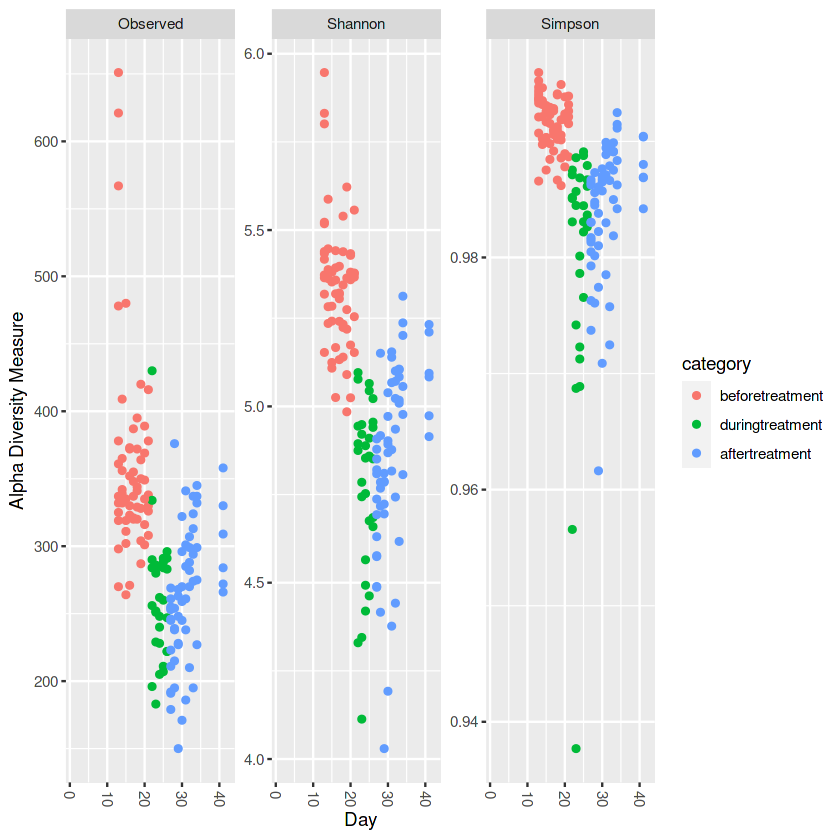

In [12]:
plot_richness(ps.pruned, x="Day", measures=c("Observed", "Shannon", "Simpson"), color="Horse") + xlim(c(1, 42))
plot_richness(ps.pruned, x="Day", measures=c("Observed", "Shannon", "Simpson"), color="category") + xlim(c(1, 42))

In [13]:
# calculate Bray-Curtis
ord.nmds.bray <- ordinate(ps.pruned, method='NMDS', distance='bray')

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2048826 
Run 1 stress 0.210798 
Run 2 stress 0.2044121 
... New best solution
... Procrustes: rmse 0.03505458  max resid 0.1463461 
Run 3 stress 0.2048538 
... Procrustes: rmse 0.0347342  max resid 0.1450869 
Run 4 stress 0.2115379 
Run 5 stress 0.2015243 
... New best solution
... Procrustes: rmse 0.0277155  max resid 0.1662601 
Run 6 stress 0.2060988 
Run 7 stress 0.2014241 
... New best solution
... Procrustes: rmse 0.005015714  max resid 0.06320859 
Run 8 stress 0.2077067 
Run 9 stress 0.2024786 
Run 10 stress 0.2066723 
Run 11 stress 0.2048833 
Run 12 stress 0.2056044 
Run 13 stress 0.20248 
Run 14 stress 0.2049997 
Run 15 stress 0.2024742 
Run 16 stress 0.2024834 
Run 17 stress 0.2029044 
Run 18 stress 0.2118243 
Run 19 stress 0.2014244 
... Procrustes: rmse 0.0001520479  max resid 0.001456764 
... Similar to previous best
Run 20 stress 0.2046083 
*** Solution reached


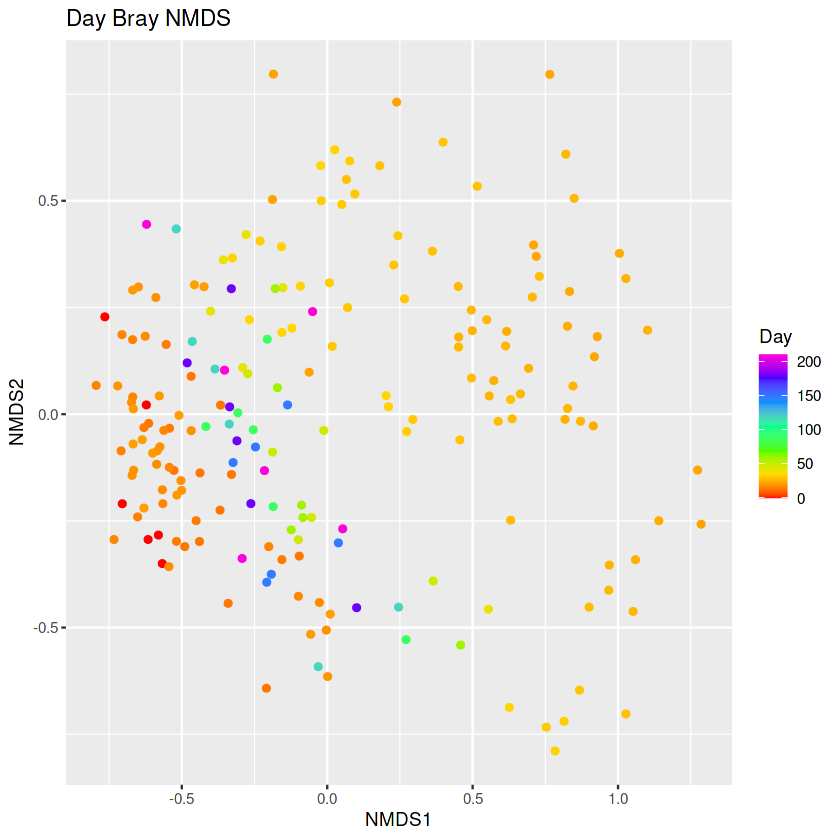

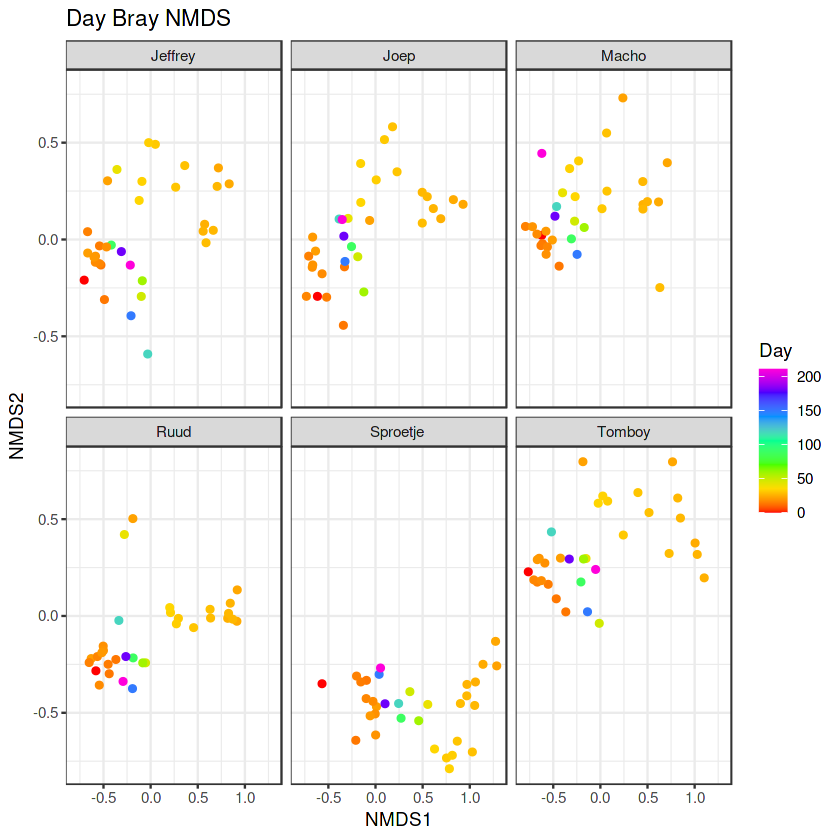

In [14]:
plot_ordination(ps.pruned, ord.nmds.bray, color="Day", title="Day Bray NMDS") + scale_color_gradientn(colours = rainbow(7))
plot_ordination(ps.pruned, ord.nmds.bray, color="Day", title="Day Bray NMDS") +
    scale_color_gradientn(colours = rainbow(7)) + 
    facet_wrap(~Horse) + theme_bw()

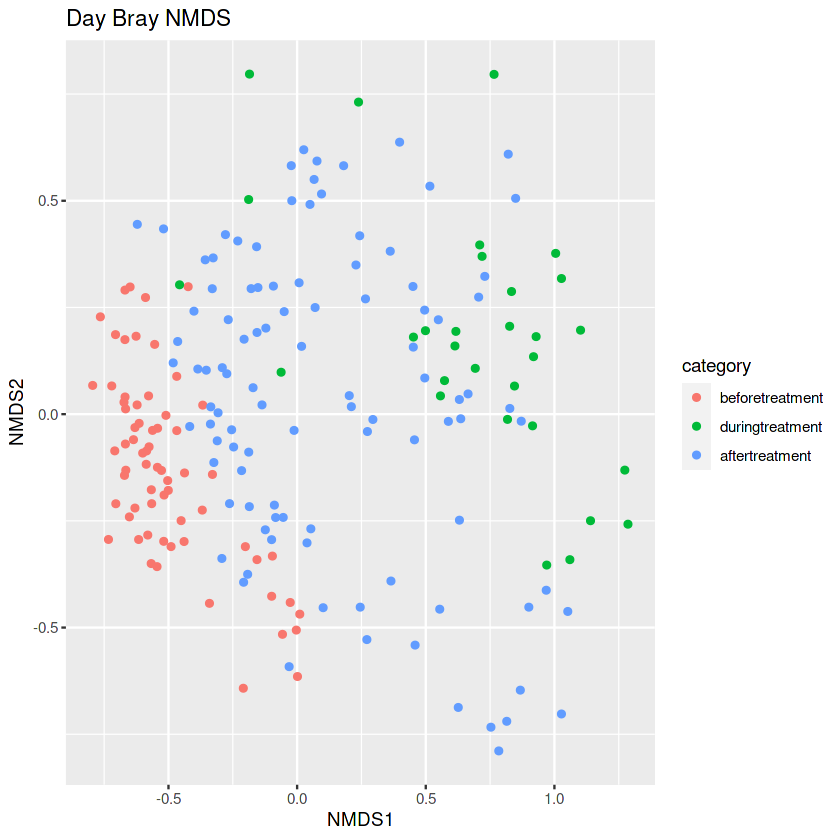

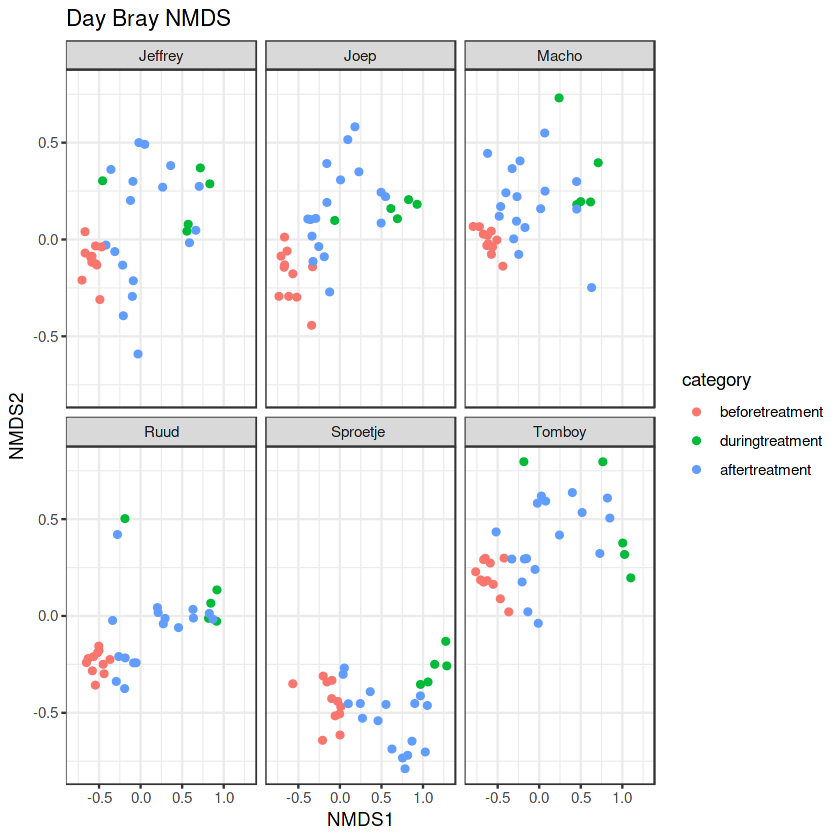

In [15]:
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS") 
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS")  + facet_wrap(~Horse) + theme_bw()

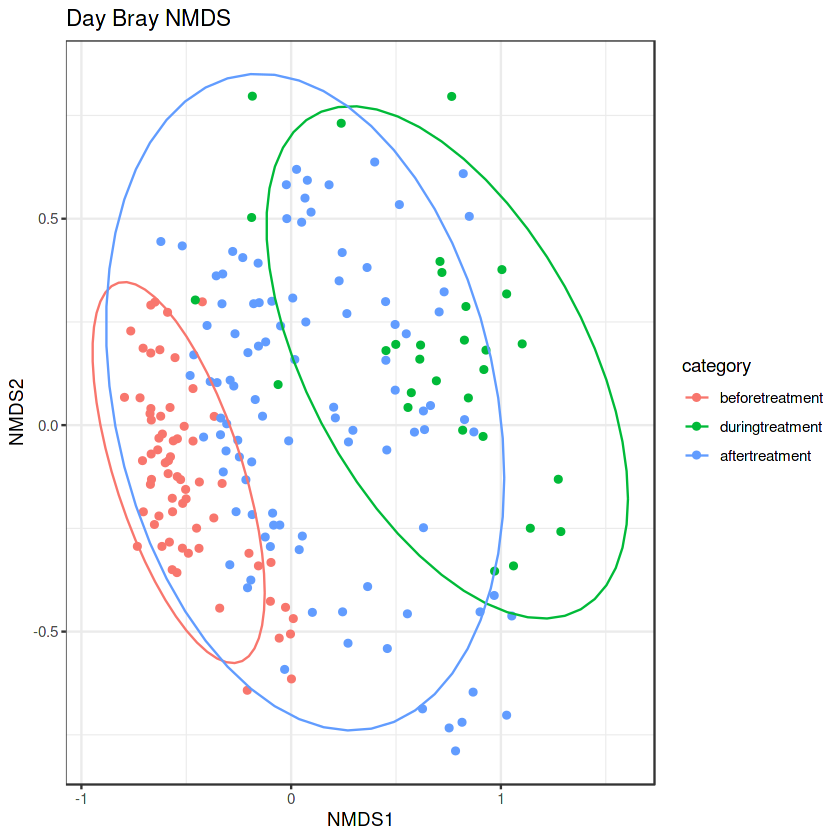

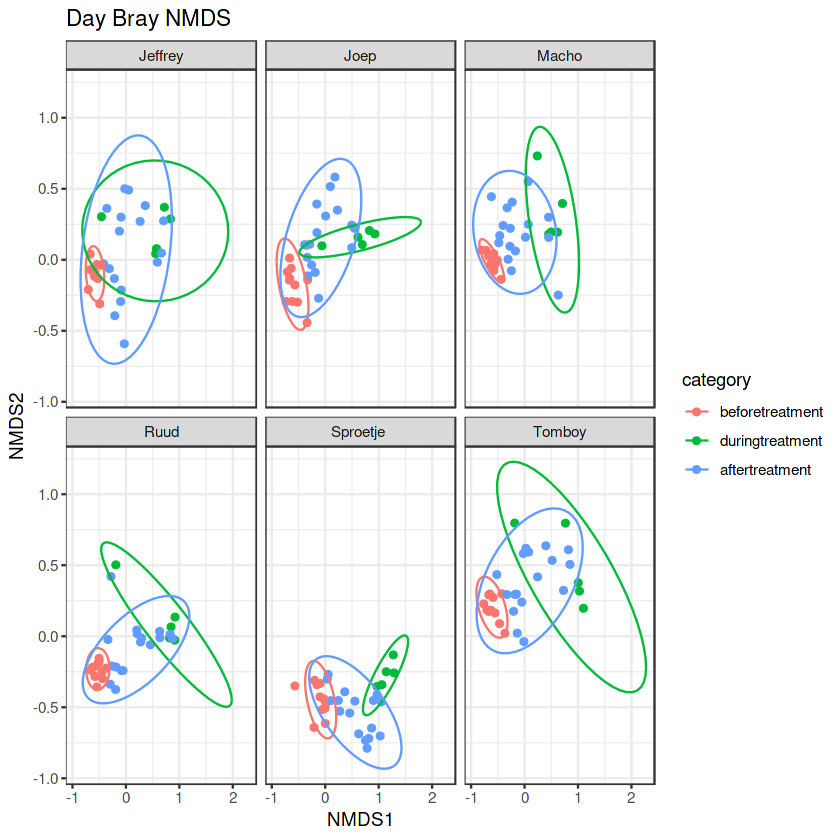

In [16]:
theme_set(theme_bw())
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS") + stat_ellipse()
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS")  + facet_wrap(~Horse) + stat_ellipse()

## PERMANOVA Test

In [17]:
sampledf <- data.frame(sample_data(ps.pruned))

# generate a distance matrix using Bray distances
ps.pruned.bray <- phyloseq::distance(ps.pruned, method='bray') 

# compare with other graphs
adonis(ps.pruned.bray ~ Horse + Day + category, data = sampledf)


Call:
adonis(formula = ps.pruned.bray ~ Horse + Day + category, data = sampledf) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Horse       5     9.674  1.9349  8.1516 0.15030  0.001 ***
Day         1     1.901  1.9010  8.0088 0.02953  0.001 ***
category    2     7.930  3.9649 16.7038 0.12320  0.001 ***
Residuals 189    44.862  0.2374         0.69697           
Total     197    64.367                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [18]:
ps.pruned.disper <- betadisper(ps.pruned.bray, sampledf$category)
permutest(ps.pruned.disper)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq  Mean Sq      F N.Perm Pr(>F)    
Groups      2 0.21962 0.109809 55.356    999  0.001 ***
Residuals 195 0.38682 0.001984                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

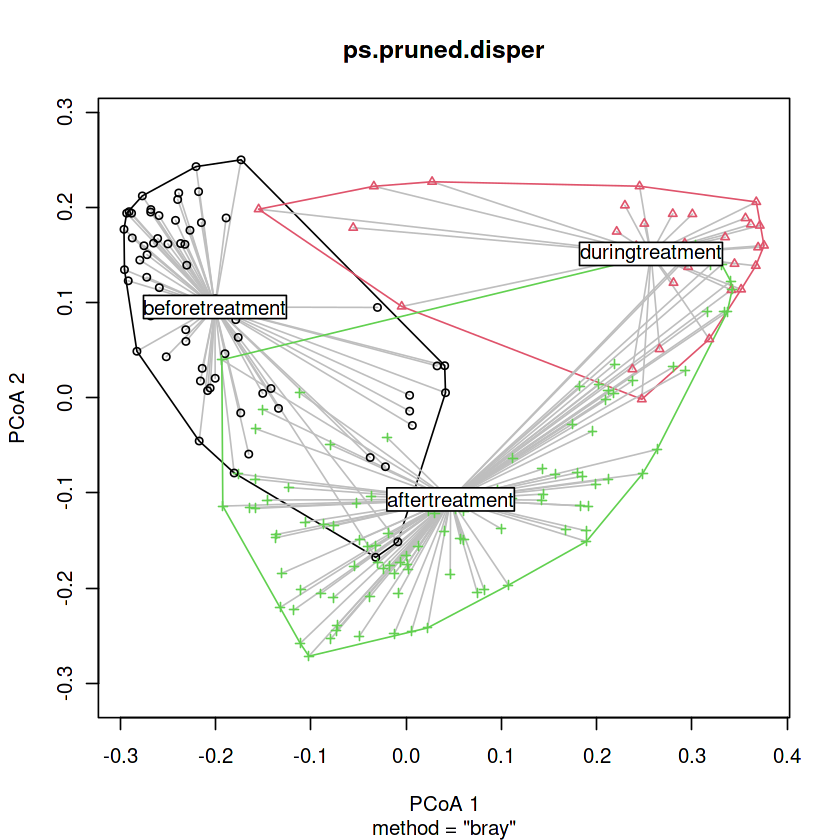

In [19]:
plot(ps.pruned.disper)

In [20]:
ps.pruned.disper


	Homogeneity of multivariate dispersions

Call: betadisper(d = ps.pruned.bray, group = sampledf$category)

No. of Positive Eigenvalues: 173
No. of Negative Eigenvalues: 24

Average distance to median:
beforetreatment duringtreatment  aftertreatment 
         0.4862          0.5274          0.5602 

Eigenvalues for PCoA axes:
(Showing 8 of 197 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
8.114 4.094 3.660 2.622 2.140 2.016 1.889 1.549 

## DESeq2 test

Task 1: what OTUs should we consider the most affected by treatment

In [21]:
# Category as the last one as it's the one being tested, the rest are cofactors
diagdds <- phyloseq_to_deseq2(ps.pruned, ~ Horse + Day + category)

gm_mean <- function(x, na.rm=TRUE) {
    exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(diagdds), 1, gm_mean)

diagdds <- estimateSizeFactors(diagdds, geoMeans = geoMeans)

diagdds <- DESeq(diagdds, fitType='local')

converting counts to integer mode

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended 

In [22]:
res <- results(diagdds)
res <- res[order(res$padj, na.last=NA), ]

alpha <- 0.01

sigtab <- res[(res$padj < alpha), ]
sigtab <- cbind(as(sigtab, 'data.frame'), as(tax_table(ps.pruned)[rownames(sigtab), ], 'matrix'))

# replace sequences w/ numbers for better viewing
rownames(sigtab) <- 1:nrow(sigtab)
head(sigtab)

baseMean  log2FoldChange lfcSE     stat      pvalue       padj        
1 10.725590 -7.359465      0.4690887 -15.68886 1.802775e-55 2.812329e-52
2 17.451601 -7.929361      0.5151291 -15.39296 1.824961e-53 1.423469e-50
3 21.275360 -8.337594      0.5985804 -13.92895 4.225461e-44 2.197240e-41
4  4.575029 -6.182232      0.4973518 -12.43030 1.789627e-35 6.979545e-33
5 11.121325 -7.635980      0.6435385 -11.86561 1.785865e-32 5.571898e-30
6  8.830387 -6.564763      0.6075947 -10.80451 3.277044e-27 8.520314e-25
  Kingdom  Phylum        Class         Order           Family            
1 Bacteria Fibrobacteres Fibrobacteria Fibrobacterales Fibrobacteraceae  
2 Bacteria Bacteroidetes Bacteroidia   Bacteroidales   F082              
3 Bacteria Firmicutes    Negativicutes Selenomonadales Acidaminococcaceae
4 Bacteria Bacteroidetes Bacteroidia   Bacteroidales   NA                
5 Bacteria Fibrobacteres Fibrobacteria Fibrobacterales Fibrobacteraceae  
6 Bacteria Firmicutes    Clostridia    Clostridiales   Ruminococcaceae   
  Genus                 Species
1 Fibrobacter           NA     
2 NA                    NA     
3 Phascolarctobacterium NA     
4 NA                    NA     
5 Fibrobacter           NA     
6 Ruminococcus_1        NA

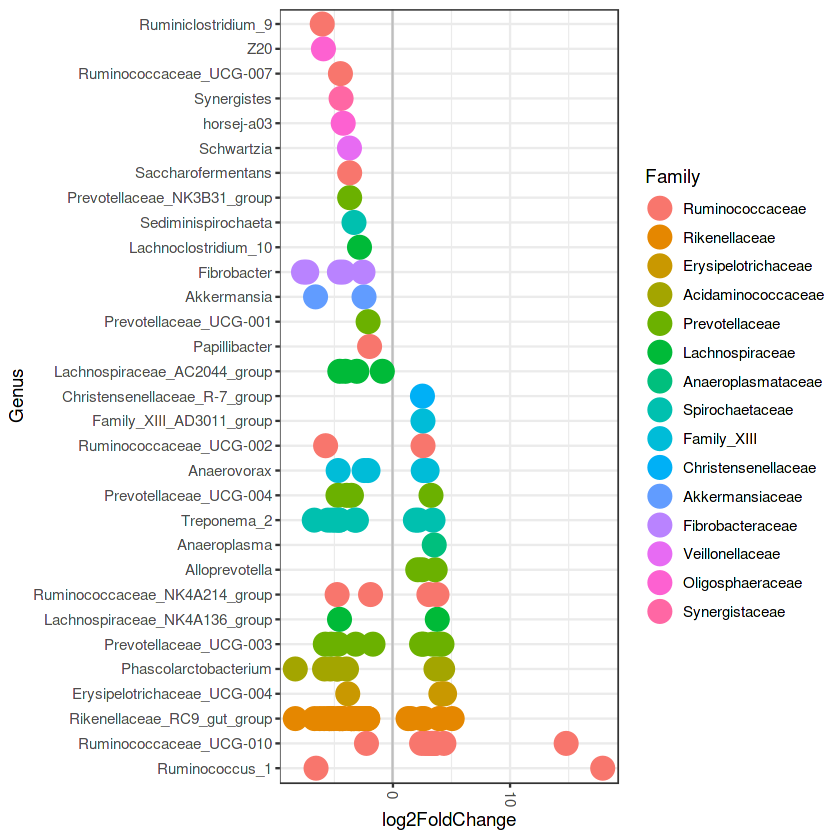

In [23]:
#relatively modest changes?
theme_set(theme_bw())
sigtabgen = subset(sigtab, !is.na(Genus))

# Family order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Family, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Family = factor(as.character(sigtabgen$Family), levels=names(x))

# Genus order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels=names(x))
ggplot(sigtabgen, aes(y=Genus, x=log2FoldChange, color=Family)) + 
  geom_vline(xintercept = 0.0, color = "gray", size = 0.5) +
  geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

But this isn't what we're looking for, as we're interested in beforetreatment vs duringtreatment. Hence we need to exclude data for aftertreatment for our analysis

In [24]:
ps.beforeduring <- subset_samples(ps.pruned, category != 'aftertreatment')

converting counts to integer mode

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended 

baseMean  log2FoldChange lfcSE    stat      pvalue       padj        
1  6.900550 -22.44773      1.156664 -19.40730 6.695839e-84 9.903146e-81
2 16.028302 -29.98836      1.634360 -18.34868 3.382061e-75 2.501034e-72
3  8.828013 -23.96713      1.471325 -16.28948 1.172175e-59 5.778824e-57
4  6.262876 -25.52245      1.676762 -15.22127 2.555206e-52 9.447875e-50
5  4.423318 -27.08061      1.817462 -14.90024 3.284014e-50 9.714114e-48
6  2.429057 -30.00000      2.109651 -14.22036 6.849561e-46 1.688417e-43
  Kingdom  Phylum        Class        Order          Family         
1 Bacteria Bacteroidetes Bacteroidia  Bacteroidales  p-251-o5       
2 Bacteria Spirochaetes  Spirochaetia Spirochaetales Spirochaetaceae
3 Bacteria Bacteroidetes Bacteroidia  Bacteroidales  Prevotellaceae 
4 Bacteria Bacteroidetes Bacteroidia  Bacteroidales  p-251-o5       
5 Bacteria Bacteroidetes Bacteroidia  Bacteroidales  F082           
6 Bacteria Bacteroidetes Bacteroidia  Bacteroidales  NA             
  Genus                  Species
1 NA                     NA     
2 Treponema_2            NA     
3 Prevotellaceae_UCG-001 NA     
4 NA                     NA     
5 NA                     NA     
6 NA                     NA

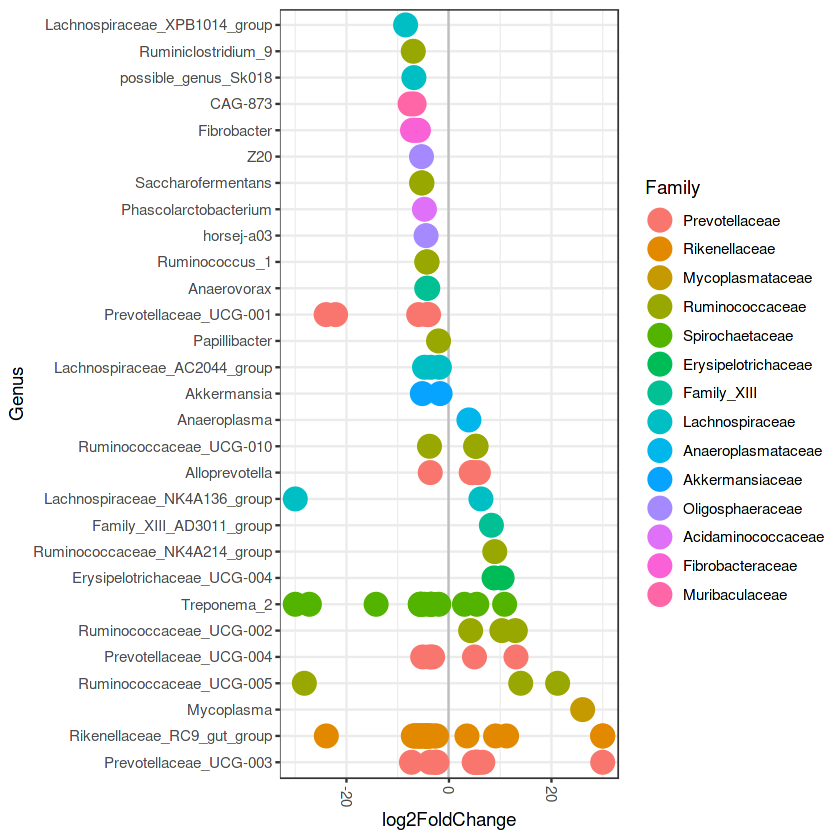

In [25]:
# category as last one. This is the one being tested, the rest is cofactor
diagdds = phyloseq_to_deseq2(ps.beforeduring, ~ Horse+Day+category) 

# calculate geometric means prior to estimate size factors
geoMeans = apply(counts(diagdds), 1, gm_mean)
diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

res = results(diagdds)
res = res[order(res$padj, na.last=NA), ]
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps.beforeduring)[rownames(sigtab), ], "matrix"))

#replace sequences with numbers for better viewing
rownames(sigtab) <- 1:nrow(sigtab)
head(sigtab)

#big changes?
theme_set(theme_bw())
sigtabgen = subset(sigtab, !is.na(Genus))

# Family order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Family, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Family = factor(as.character(sigtabgen$Family), levels=names(x))

# Genus order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels=names(x))
ggplot(sigtabgen, aes(y=Genus, x=log2FoldChange, color=Family)) + 
  geom_vline(xintercept = 0.0, color = "gray", size = 0.5) +
  geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

## ML Prediction

Task 2: After how many days does the microbiome return to pre-treatment using ML methods?

Task 3: Explain how we can identify the correct day. 

We can use Randomforest and get votes beforetreatment. Afterwards, plot votesbeforetreatment vs day, then see when votes return to approximately original level. The plot should form a j-shape.

In [26]:
# get features

featureMat <- otu_table(ps.beforeduring)

In [27]:
# get labels
labels <- sample_data(ps.beforeduring)$category

In [28]:
tapply(labels, labels, length)

beforetreatment duringtreatment 
             66              30

In [29]:
# Run random forest
rf <- randomForest(formula = y ~ x, x=featureMat, 
                  y = as.factor(labels),
                  ntree = 1000, sampsize = (c(20, 20)))

rf


Call:
 randomForest(x = featureMat, y = as.factor(labels), ntree = 1000,      sampsize = (c(20, 20)), formula = y ~ x) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 39

        OOB estimate of  error rate: 0%
Confusion matrix:
                beforetreatment duringtreatment class.error
beforetreatment              66               0           0
duringtreatment               0              30           0

In [30]:
# put all data into a matrix for prediction
featureMat_all <- otu_table(ps.pruned)

In [31]:
votes <- predict(rf, featureMat_all, type='vote')
votes

beforetreatment duringtreatment
S2T0A  0.923           0.077          
S2T0B  0.848           0.152          
S2T0C  0.934           0.066          
S2T0D  0.945           0.055          
S2T0E  0.926           0.074          
S2T0F  0.877           0.123          
S2T10A 0.902           0.098          
S2T10B 0.939           0.061          
S2T10C 0.939           0.061          
S2T10D 0.919           0.081          
S2T10E 0.809           0.191          
S2T10F 0.665           0.335          
S2T11A 0.237           0.763          
S2T11B 0.206           0.794          
S2T11C 0.123           0.877          
S2T11D 0.191           0.809          
S2T11E 0.043           0.957          
S2T11F 0.182           0.818          
S2T12A 0.021           0.979          
S2T12B 0.018           0.982          
S2T12C 0.020           0.980          
S2T12D 0.021           0.979          
S2T12E 0.023           0.977          
S2T12F 0.047           0.953          
S2T13A 0.023           0.977          
S2T13B 0.022           0.978          
S2T13C 0.030           0.970          
S2T13D 0.018           0.982          
S2T13E 0.018           0.982          
S2T13F 0.026           0.974          
S2T14A 0.063           0.937          
S2T14B 0.027           0.973          
S2T14C 0.071           0.929          
S2T14D 0.041           0.959          
S2T14E 0.029           0.971          
S2T14F 0.053           0.947          
S2T15A 0.063           0.937          
S2T15B 0.061           0.939          
S2T15C 0.082           0.918          
S2T15D 0.072           0.928          
S2T15E 0.094           0.906          
S2T15F 0.062           0.938          
S2T16A 0.230           0.770          
S2T16B 0.174           0.826          
S2T16C 0.193           0.807          
S2T16D 0.103           0.897          
S2T16E 0.141           0.859          
S2T16F 0.187           0.813          
S2T17A 0.203           0.797          
S2T17B 0.219           0.781          
S2T17C 0.220           0.780          
S2T17D 0.124           0.876          
S2T17E 0.156           0.844          
S2T17F 0.176           0.824          
S2T18A 0.207           0.793          
S2T18B 0.270           0.730          
S2T18C 0.330           0.670          
S2T18D 0.076           0.924          
S2T18E 0.220           0.780          
S2T18F 0.150           0.850          
S2T19A 0.335           0.665          
S2T19B 0.396           0.604          
S2T19C 0.494           0.506          
S2T19D 0.228           0.772          
S2T19E 0.320           0.680          
S2T19F 0.317           0.683          
S2T1A  0.970           0.030          
S2T1B  0.789           0.211          
S2T1C  0.945           0.055          
S2T1D  0.917           0.083          
S2T1E  0.808           0.192          
S2T1F  0.844           0.156          
S2T20A 0.366           0.634          
S2T20B 0.330           0.670          
S2T20C 0.441           0.559          
S2T20D 0.294           0.706          
S2T20E 0.343           0.657          
S2T20F 0.409           0.591          
S2T21A 0.440           0.560          
S2T21B 0.449           0.551          
S2T21C 0.432           0.568          
S2T21D 0.359           0.641          
S2T21E 0.354           0.646          
S2T21F 0.382           0.618          
S2T22A 0.491           0.509          
S2T22B 0.520           0.480          
S2T22C 0.567           0.433          
S2T22D 0.392           0.608          
S2T22E 0.318           0.682          
S2T22F 0.508           0.492          
S2T23A 0.516           0.484          
S2T23B 0.637           0.363          
S2T23C 0.577           0.423          
S2T23D 0.411           0.589          
S2T23E 0.324           0.676          
S2T23F 0.494           0.506          
S2T24A 0.594           0.406          
S2T24B 0.630           0.370          
S2T24C 0.657           0.343          
S2T24D 0.384           0.616          
S2T24E 0.339           0.661          
S2T24F 0.495           0.505 

In [32]:
sample_data(ps.pruned)$votesbeforetreatment <- votes[,1]
sample_data(ps.pruned)$votesaftertreatment <- votes[,2]

In [33]:
sample_data(ps.pruned)

Day Horse     category        votesbeforetreatment votesaftertreatment
S2T0A    0 Jeffrey   beforetreatment 0.923                0.077              
S2T0B    0 Joep      beforetreatment 0.848                0.152              
S2T0C    0 Macho     beforetreatment 0.934                0.066              
S2T0D    0 Ruud      beforetreatment 0.945                0.055              
S2T0E    0 Sproetje  beforetreatment 0.926                0.074              
S2T0F    0 Tomboy    beforetreatment 0.877                0.123              
S2T10A  21 Jeffrey   beforetreatment 0.902                0.098              
S2T10B  21 Joep      beforetreatment 0.939                0.061              
S2T10C  21 Macho     beforetreatment 0.939                0.061              
S2T10D  21 Ruud      beforetreatment 0.919                0.081              
S2T10E  21 Sproetje  beforetreatment 0.809                0.191              
S2T10F  21 Tomboy    beforetreatment 0.665                0.335              
S2T11A  22 Jeffrey   duringtreatment 0.237                0.763              
S2T11B  22 Joep      duringtreatment 0.206                0.794              
S2T11C  22 Macho     duringtreatment 0.123                0.877              
S2T11D  22 Ruud      duringtreatment 0.191                0.809              
S2T11E  22 Sproetje  duringtreatment 0.043                0.957              
S2T11F  22 Tomboy    duringtreatment 0.182                0.818              
S2T12A  23 Jeffrey   duringtreatment 0.021                0.979              
S2T12B  23 Joep      duringtreatment 0.018                0.982              
S2T12C  23 Macho     duringtreatment 0.020                0.980              
S2T12D  23 Ruud      duringtreatment 0.021                0.979              
S2T12E  23 Sproetje  duringtreatment 0.023                0.977              
S2T12F  23 Tomboy    duringtreatment 0.047                0.953              
S2T13A  24 Jeffrey   duringtreatment 0.023                0.977              
S2T13B  24 Joep      duringtreatment 0.022                0.978              
S2T13C  24 Macho     duringtreatment 0.030                0.970              
S2T13D  24 Ruud      duringtreatment 0.018                0.982              
S2T13E  24 Sproetje  duringtreatment 0.018                0.982              
S2T13F  24 Tomboy    duringtreatment 0.026                0.974              
S2T14A  25 Jeffrey   duringtreatment 0.063                0.937              
S2T14B  25 Joep      duringtreatment 0.027                0.973              
S2T14C  25 Macho     duringtreatment 0.071                0.929              
S2T14D  25 Ruud      duringtreatment 0.041                0.959              
S2T14E  25 Sproetje  duringtreatment 0.029                0.971              
S2T14F  25 Tomboy    duringtreatment 0.053                0.947              
S2T15A  26 Jeffrey   duringtreatment 0.063                0.937              
S2T15B  26 Joep      duringtreatment 0.061                0.939              
S2T15C  26 Macho     duringtreatment 0.082                0.918              
S2T15D  26 Ruud      duringtreatment 0.072                0.928              
S2T15E  26 Sproetje  duringtreatment 0.094                0.906              
S2T15F  26 Tomboy    duringtreatment 0.062                0.938              
S2T16A  27 Jeffrey   aftertreatment  0.230                0.770              
S2T16B  27 Joep      aftertreatment  0.174                0.826              
S2T16C  27 Macho     aftertreatment  0.193                0.807              
S2T16D  27 Ruud      aftertreatment  0.103                0.897              
S2T16E  27 Sproetje  aftertreatment  0.141                0.859              
S2T16F  27 Tomboy    aftertreatment  0.187                0.813              
S2T17A  27 Jeffrey   aftertreatment  0.203                0.797              
S2T17B  27 Joep      aftertreatment  0.219                0.781              
S2T17C  27 Macho     aftertre

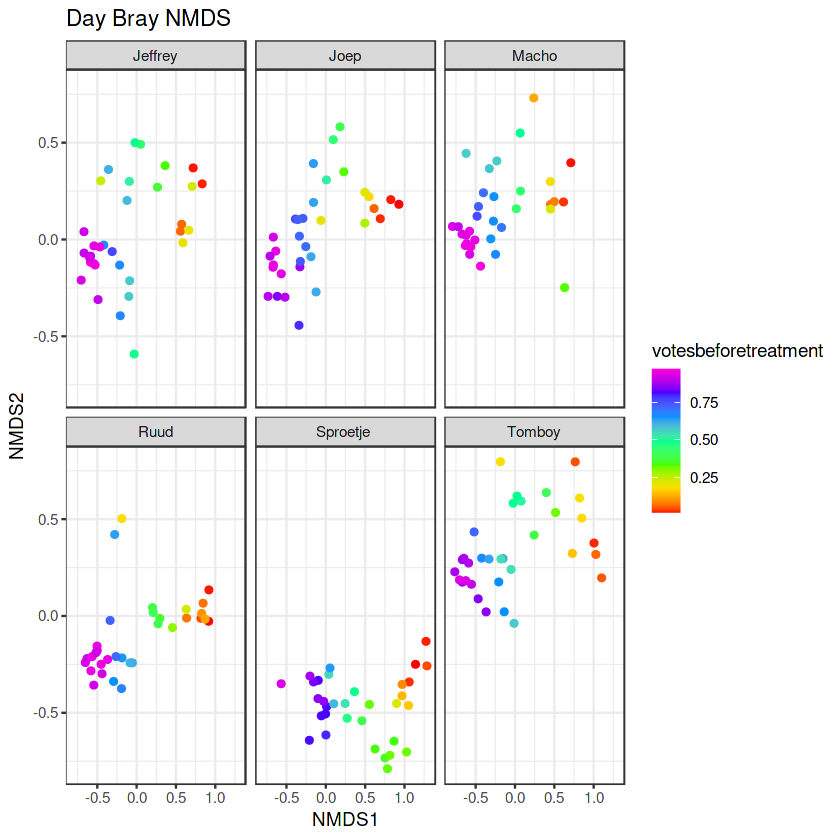

In [34]:
plot_ordination(ps.pruned, ord.nmds.bray, color="votesbeforetreatment", title="Day Bray NMDS") +
    scale_color_gradientn(colours = rainbow(7)) + 
    facet_wrap(~Horse)

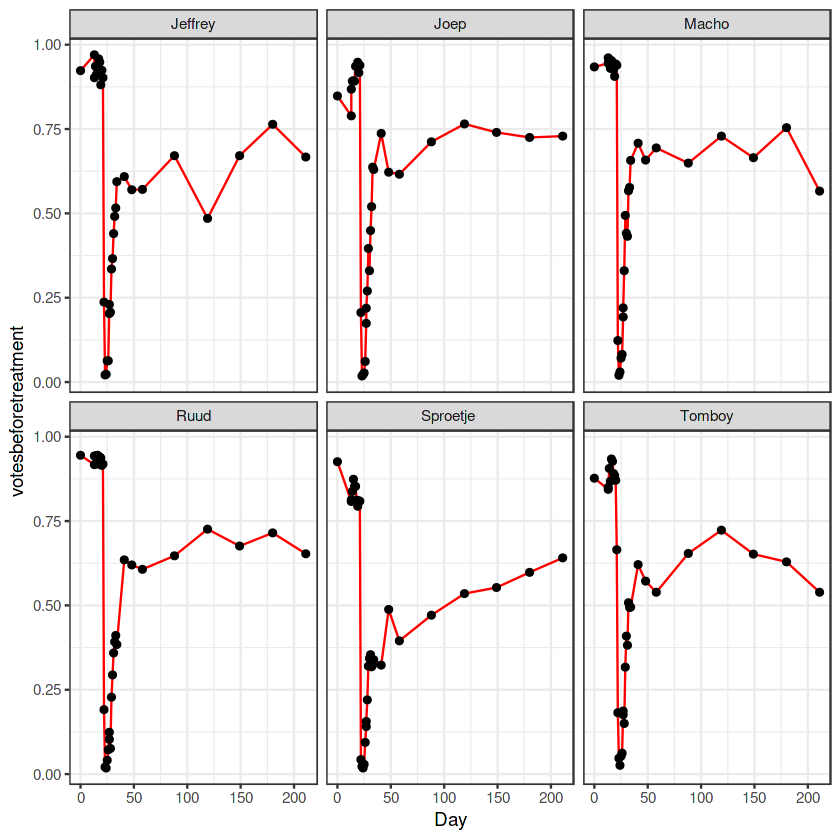

In [35]:
ggplot(sample_data(ps.pruned), aes(x=Day, y=votesbeforetreatment, group=Horse)) + 
    geom_line(color='red') + 
    geom_point() + 
    facet_wrap(~Horse)

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”
Warning message:
“Removed 42 rows containing missing values (geom_point).”


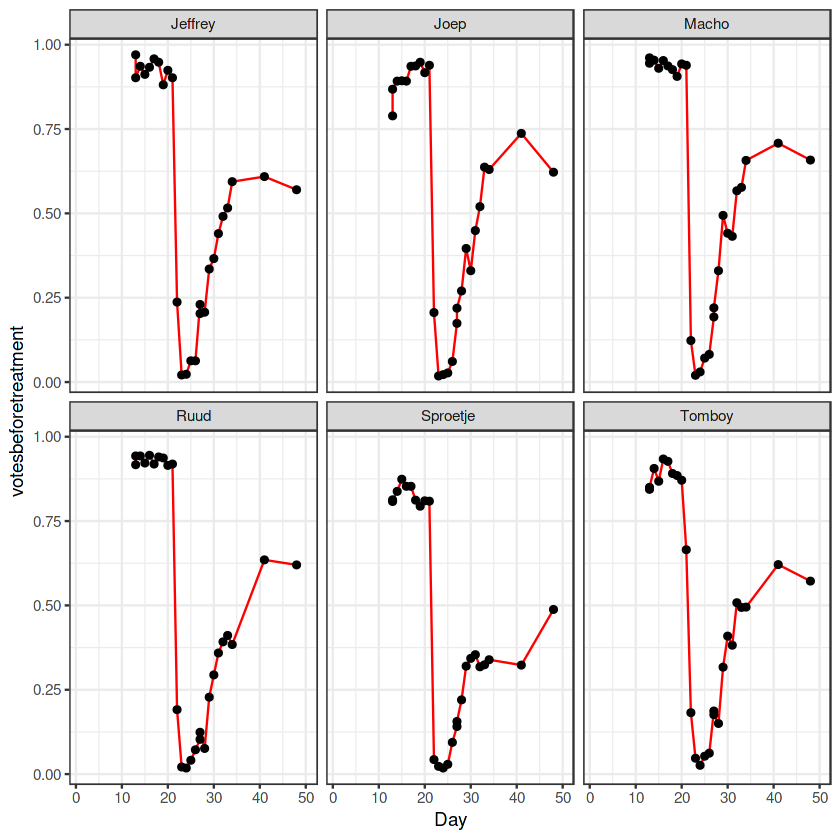

In [36]:
ggplot(data=sample_data(ps.pruned), aes(x=Day, y=votesbeforetreatment, group=Horse)) +
  geom_line(color="red")+
  geom_point() + 
  facet_wrap(~Horse) +
  xlim(1,50)

In [37]:
rf$importance

MeanDecreaseGini
CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG       0.036656991     
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG       0.057069044     
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGAAGGATGACGGCCCTATGGGTTGTAAACTTCTTTTTCCGGGGGATAAAGTGACCCACGTGTGGGTTATTGCAGGTACCCGGTGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGAAATGTAAGTCAGCCGTCAAATCGCGGAGCTCAACTCCGTCCAGCGGTTGAAACTGCGTTTCTTGAGTGCGCAAGAGGCAGGTGGAATTCGAGGTGTAGCGGTGAAATGCTTAGATATCTCGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGGGCGCAACTGACGCTGAGGCTCGAAGGTGCGGGTATCAAACAGGATTAG        0.003610025     
CAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTGTACGGGAATAAAGTGACCTACGTGTAGGTTTTTGCATGTACCGTAAGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTGCTTTAAGCGTGTTGTGAAATGTAGGCGCCCAACGTCTGCACTGCAGCGCGAACTGGAGCACTTGAGTACGCAGGAAGTAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGGGAAGCCAGCTTACTGTAGCGCCACTGACGCTGATGCTCGAAAGCGTGGGTATCGAACAGGATTAG       0.015048705     
CAGTGGGGAATATTGGACAATGGGGGAAACCCTGATCCAGCGACGCCGCGTGAGTGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAAGGAAGAAAATGACGGTACTTGACTAAGAAGCTCCGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAAGCAAGTCTGAAGTGAAATCCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTAGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAG                           0.041982422     
CAGTAGGGAATATTGGGCAATGGAGGCAACTCTGACCCAGCCATGCCGCGTGAAGGAAGACGGCCCTATGGGTTGTAAACTTCTTTTATCGTAGAGTAAACCTGGCCACGTGTGGCCAGCTGAGAGTATACGAGGAATAAGTATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGGGGATACGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGATCGGTAAGTCAGGGGTGAAAAGTTGGGGCTCAACTCCAATCGTGCCTTTGATACTGCCGGACTAGAGTGCGATAGACGTGGCCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATCGAGAAGTCAGGTCACGAGCTCGCAACTGACGCTCAGGCACGAAAGCGTGGGGATCAAACAGGATTAG       0.012223232     
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAAGGAATAATGCCTGGTCTCGGCCAGGTTGAATGTACTTTGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGCAGGCGGAGATGCAAGCGGTCTGTACAATCCCGGGGCCTAACCCCGGACCTGCAGACCGGACTGTTTCTCTTGGATAGCTCAGGGGCTGGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCCAGCTGGGGGCTTATCGACGCTCATGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          0.036550923     
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCATGTCGCGTGCAGGAATACGGCCCTACGGGTTTTAAACTGCTTTTGCCTGGGGATAAAGTGGCGGACGAGTCCGCTATTGCAGGTACCAGGCGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCACGCCAAGTCTGCGGTGAAATGTCAGGGCTCAACCTTGGCACTGCCATGGAAACTGGCGAGCTAGAGTGCGTTTGGGGTACATGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACGCCGATCGCGAAGGCAGTGTACCAAGCCGCAACTGACGCTGAGGCACGAAAGTGCGGGGATCGAACAGGATTAG       0.391519091     
CAGTGAGGAATATTGGTCAATGGGCGCGAGCCTGAACCAGCCAAGTAGCGTGAGGGAAGACGGCCCTACGGGTTGTAAACCTCTTTTGCGCGGGAATAAAGTCAGCCACGTGTGGCTGTTTGCATGTACCGCGGGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCCGCCTTTTAAGCGTGTTGTGAAATGCGGGCGCCCAACGTCCGCACTGCAGCGCGAACTGGAGGGCTTGAGTTTGCGGAAAGAAGGCGGAATTCGTTGTGTAGCGGTGA

In [38]:
combined_taxa_importances <- as.data.frame(tax_table(ps.pruned))

In [39]:
combined_taxa_importances$importance <- rf$importance[, 1]

In [40]:
combined_taxa_importances

Kingdom 
CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGAAGGATGACGGCCCTATGGGTTGTAAACTTCTTTTTCCGGGGGATAAAGTGACCCACGTGTGGGTTATTGCAGGTACCCGGTGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGAAATGTAAGTCAGCCGTCAAATCGCGGAGCTCAACTCCGTCCAGCGGTTGAAACTGCGTTTCTTGAGTGCGCAAGAGGCAGGTGGAATTCGAGGTGTAGCGGTGAAATGCTTAGATATCTCGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGGGCGCAACTGACGCTGAGGCTCGAAGGTGCGGGTATCAAACAGGATTAG        Bacteria
CAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTGTACGGGAATAAAGTGACCTACGTGTAGGTTTTTGCATGTACCGTAAGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTGCTTTAAGCGTGTTGTGAAATGTAGGCGCCCAACGTCTGCACTGCAGCGCGAACTGGAGCACTTGAGTACGCAGGAAGTAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGGGAAGCCAGCTTACTGTAGCGCCACTGACGCTGATGCTCGAAAGCGTGGGTATCGAACAGGATTAG       Bacteria
CAGTGGGGAATATTGGACAATGGGGGAAACCCTGATCCAGCGACGCCGCGTGAGTGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAAGGAAGAAAATGACGGTACTTGACTAAGAAGCTCCGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAAGCAAGTCTGAAGTGAAATCCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTAGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAG                           Bacteria
CAGTAGGGAATATTGGGCAATGGAGGCAACTCTGACCCAGCCATGCCGCGTGAAGGAAGACGGCCCTATGGGTTGTAAACTTCTTTTATCGTAGAGTAAACCTGGCCACGTGTGGCCAGCTGAGAGTATACGAGGAATAAGTATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGGGGATACGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGATCGGTAAGTCAGGGGTGAAAAGTTGGGGCTCAACTCCAATCGTGCCTTTGATACTGCCGGACTAGAGTGCGATAGACGTGGCCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATCGAGAAGTCAGGTCACGAGCTCGCAACTGACGCTCAGGCACGAAAGCGTGGGGATCAAACAGGATTAG       Bacteria
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAAGGAATAATGCCTGGTCTCGGCCAGGTTGAATGTACTTTGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGCAGGCGGAGATGCAAGCGGTCTGTACAATCCCGGGGCCTAACCCCGGACCTGCAGACCGGACTGTTTCTCTTGGATAGCTCAGGGGCTGGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCCAGCTGGGGGCTTATCGACGCTCATGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          Bacteria
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCATGTCGCGTGCAGGAATACGGCCCTACGGGTTTTAAACTGCTTTTGCCTGGGGATAAAGTGGCGGACGAGTCCGCTATTGCAGGTACCAGGCGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCACGCCAAGTCTGCGGTGAAATGTCAGGGCTCAACCTTGGCACTGCCATGGAAACTGGCGAGCTAGAGTGCGTTTGGGGTACATGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACGCCGATCGCGAAGGCAGTGTACCAAGCCGCAACTGACGCTGAGGCACGAAAGTGCGGGGATCGAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGCGAGCCTGAACCAGCCAAGTAGCGTGAGGGAAGACGGCCCTACGGGTTGTAAACCTCTTTTGCGCGGGAATAAAGTCAGCCACGTGTGGCTGTTTGCATGTACCGCGGGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCCGCCTTTTAAGCGTGTTGTGAAATGCGGGCGCCCAACGTCCGCACTGCAGCGCGAACTGGAGGGCTTGAGTTTGCGGAAAGAAGGCGGAATTCGTTGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGCGAAGGCAGCCTTCTGCAGCATTACTGACGCTAAAGCTCGA

In [41]:
combined_taxa_importances[order(combined_taxa_importances[,8]), ]

Kingdom 
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAGGGAATAATGCTTGGTTTCGGCCAAGTTGAATGTACCTCGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGCAGGCGGAGATGCAAGCAGTCTGTACAATACCGGGGCCCAACCCCGGACCTGCAGACTGGACTGTTTCTCTTGGATAGTTCAGGGGCAAGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCTTGCTGGGGACTTATCGACGCTCATGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          Bacteria
CAGTGAGGAATATTGGTCAATGGGCGCGAGCCTGAACCAGCCAAGTAGCGTGCAGGACGACGGCCCTCCGGGTTGTAAACTGCTTTTAGTTGGGAATAAAAGAGCGTACGCGTACGCTGTATTGTATGTACCATCAGAAAAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACTTTTAAGTCAGCTGTGAAATCCTGCGGCTCAACCGTGGAATTGCAGTTGAAACTGGGAGTCTTGAGTGCACGCAGGGATGCCGGAATTCGTTGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATCGCGAAGGCAAGTGTCCGGAGTGCAACTGACGCTGAGGCTCGAAAGTGTGGGTATCAAACAGGATTAG     Bacteria
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAGGGAATAATGCTATTTTTCGGAATAGTTGAATGTACCTCGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGTAGGCGGAAATGCAAGCAATCTGTACAATACCGGGGCCCAACCCCGGACCTGCAGATTGGACTGTGTTTCTTGGATAGTTCAGGGGCAGGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCCTGCTGGGGACTTATCGACGCTGAGGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          Bacteria
CAGTGAGGAATATTGGACAATGGAGGCAACTCTGATCCAGCCATGCCGCGTGAAGGACTAAGGCCCTACGGGTCGTAAACTTCTTTTGACGCAGGGCAATAAGGCGTACGTGTACGCCGATGAGAGTATGCGTCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGATGATTAAGTCAGTGGTGAAAGGTCCCGGCTCAACCGGGGAGCTGCCATTGATACTGGTCGTCTTGAATGCGGATGCCGTGGGAGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACACCGATTGCGAAGGCATCTCACGAATCCGTTATTGACGCTGAGGCACGAAAGCGTGGGGATCAAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGGAAGCCTGAACCAGCCAAGTCGCGTGCGGGACGAAGGCCCTACGGGTCGTAAACCGCTTTTGTACGGGAATAAAAAACTCCACGCGTGGGGTCTTGTAGGTACCGTAAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGGCTGCTAAGTCTCCGGTGAAATGTCAGGGCTCAACCTTGGAATTGCCGGAGATACTGGCGGCCTTGAGAGTGGCGGAGGTATCCGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACACCGATTGCGAAGGCAGGATACCATACCATATCTGACGCTCAGGCACGAAAGCGTGGGGATCGAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGGAAGCCTGAACCAGCCAAGTCGCGTGAAGGATGAAGGTATTATGTATTGTAAACTTCTTTAGATGCAGAGAAATAAGCCCCTCGTGAGGGGTGATGCTAGTATGCATAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGCTTTTTAAGTCAGCGGTCAAATCGTGAGGCTCAACCTCATCCCGCCGTTGATACTGGAAGGCTTGATTGCGGTCGAGGTAGGCGGAATTCGTCGTGTAGCGGTGAAATGCATAGATATGACGAAGAACACCGATTGCGTAGGCAGCTTACCAGACCGTAAATGACGCTCATGCACGAAAGTGCGGGGATCGAACAGGATTAG        Bacteria
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGAGCCACGTGTGGTTCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG       Bacteria
CAGTAGGGAGTTTTCGGCAATGGGGGAAACCCTGACCGAGCAACGCCGCGTGAATGATGAAGGTCTTCGGATTGTAAAGTTCTGTTATAAGGGAAAAATGATAGGGTGAGGAAATGCTCTCTATTTGATGGTACCTTATTAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTGAGCAGGCGGCATGGTAAGTTTGAAGTGAAAGCGTGGGGCTTAACCCCATACAGCTTCGAAAACTGCCAGGCTAGAGTGCGGGAGAGGTAAACGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGTTTACTAGCCCGATACTGACGCTCAGTCACGAAAGCGTGGGGAGCAAATAGGATTAG   Bacteria
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCAAGTCGCGTGCAGGAAGACGGTCCTATGGATTGTAAACTGCTTTTGTACGGGAATAAAGTGGGGGACGTGTCCCCCTTGGAATGTACCGTAAGAATAAGGGTCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGACCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGAGGATTAAGTCAGCGGTGAAATTCTCATGCTCAACATGAGAACTGCCATTGATACTGGTCCCCTTGAGAGATGTCGAGGATGGCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATTGCGAAGGCAGCTGTCCAGAGATCATCTGACGCTCAGGCACGA